<a href="https://colab.research.google.com/github/aidancrilly/AIMSLecture/blob/main/02_DifferentiableSimulatorsAndOptimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2

Resources:

- JAX [documentation](https://jax.readthedocs.io/en/latest/quickstart.html)
- Patrick Kidger "On Neural Differential Equations" [ArXiv link](https://arxiv.org/abs/2202.02435)

Note: need to install diffrax and optax libraries as not installed by default on colab

In [ ]:
!pip install diffrax optax
import diffrax
import optax
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

# Part 1

For the following exercises we are going to introduce two JAX libraries which will allow us to easily write and train differentiable simulators:

1. diffrax - https://docs.kidger.site/diffrax/
2. optax - https://optax.readthedocs.io/en/latest/getting_started.html

These libraries allow for the numerical forward and adjoint solution to differential equations (diffrax) and the solving of optimisation problems (optax).

First, we introduce diffrax. The key features of diffrax we need to use are:

1. ODETerms, these wrap python functions of the form:
```
def dydt(t : float, y : JAX array, args : dict):
    return dydt_val : JAX array
```
which return the right hand side of your differential equation.

2. Solvers, these implement different numerical methods for evolving in time. For example, Euler's method is available as well as other higher order methods.

3. Step size controllers, the solvers we will use are adaptive (they vary the time step used) so these controllers are used to decide what step size to take to obtain a prescribed accuracy

4. SaveAts, these simply provide a number of points in time when the numerical solution should be saved and returned to the user.

Using these features, diffrax numerically solves the following equation:

$$
y(t_1) = y(t_0) + \int_{t_0}^{t_1} \frac{dy}{dt} dt
$$

and thus we must also specify the time interval $[t_0,t_1]$ and the intitial conditions $y(t_0) \equiv y_0$.

## Part a

We will first learn to use the key features of diffrax using the exponential decay ODE example from the previous exercise.


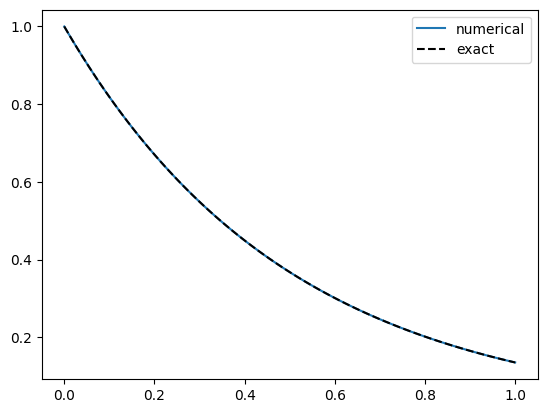

In [ ]:
def dydt(t,y,args):
  return -y/args['tau']

def diffrax_solve(dydt,t0,t1,Nt,rtol=1e-5,atol=1e-5):
  """
  Here we wrap the diffrax diffeqsolve function such that we can run with
  different y0s and taus over the same time interval easily
  """
  # We convert our python function to a diffrax ODETerm
  term = diffrax.ODETerm(dydt)
  # We chose a solver (time-stepping) method from within diffrax library
  # Heun's method (https://en.wikipedia.org/wiki/Heun%27s_method)
  solver = diffrax.Heun()

  # At what time points you want to save the solution
  saveat = diffrax.SaveAt(ts=jnp.linspace(t0,t1,Nt))
  # Diffrax uses adaptive time stepping to gain accuracy within certain tolerances
  stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)

  return lambda y0,tau : diffrax.diffeqsolve(term, solver,
                         y0=y0, args = {'tau' : tau},
                         t0=t0, t1=t1, dt0=(t1-t0)/Nt,
                         saveat=saveat, stepsize_controller=stepsize_controller)

t0 = 0.0
t1 = 1.0
Nt = 100

ODE_solve = diffrax_solve(dydt,t0,t1,Nt)

# Solve for specific y0 and tau
y0 = 1.0
tau = 0.5
sol = ODE_solve(y0,tau)

plt.plot(sol.ts,sol.ys)
plt.plot(sol.ts,y0*jnp.exp(-sol.ts/tau),'k--')
plt.legend(['numerical','exact'])
plt.show()

Diffrax solutions are differentiable by construction - see https://docs.kidger.site/diffrax/api/adjoints/ for details.

We can therefore very easily solve the adjoint state problem using diffrax and JAX AD:

In [ ]:
def loss(inputs):
  y0 = inputs['y0']
  tau = inputs['tau']
  sol = ODE_solve(y0,tau)
  return sol.ys[-1]

inputs = {'y0' : y0, 'tau' : tau}
# Returns gradient of loss with respect to all inputs, i.e. dLdtau and dLdy0
jax.grad(loss)(inputs)

{'tau': Array(0.54133505, dtype=float32, weak_type=True),
 'y0': Array(0.13533837, dtype=float32, weak_type=True)}

## Part b

So far we have only considered ordinary differential equations, the only derviatives that appeared were total derivates w.r.t. time. However, Partial Differential Equations (PDEs) are key to physics modelling and involve partial derivatives w.r.t. multiple variables.

To solve PDEs with diffrax, we will use the method of lines (https://en.wikipedia.org/wiki/Method_of_lines), leaving time as a continuous variable. Therefore we can write our dydt function needed for the diffrax ODETerm and allow diffrax to handle the time differencing.

In the following exercise we are concerned with the following transport equation over the ($t,x,\mu$) domain:

$$ \frac{\partial f}{\partial t} = -\mu \frac{\partial f}{\partial x} + \sigma \left(\frac{1}{2}\phi - f \right)+ \frac{1}{2} S(x,t) $$
$$ \phi(x,t) = \int f(x,\mu,t) d\mu $$

Physically, this equation represents the transport of an ensemble of scattering particles in one spatial dimension, $x$. The direction domain, $\mu \equiv \cos(\theta)$, is bounded to between $\pm 1$. The scattering rate, $\sigma$, is a single scalar which dictates the dynamics of the system.

Applying finite differening (https://en.wikipedia.org/wiki/Finite_difference_method) and the method of lines to the above equation gives us the following numerical equations:

$$
\mu_m > 0 \ , \ \frac{\partial f_{i,m}}{\partial t} = -\mu_m \frac{f_{i+1,m}-f_{i,m}}{\Delta x} + \sigma \left(\frac{1}{2}\phi_i - f_{i,m} \right)+ \frac{1}{2} S(x_i,t) \\
\mu_m < 0 \ , \ \frac{\partial f_{i,m}}{\partial t} = -\mu_m \frac{f_{i,m}-f_{i-1,m}}{\Delta x} + \sigma \left(\frac{1}{2}\phi_i - f_{i,m} \right)+ \frac{1}{2} S(x_i,t) \\
\phi_i = \sum_m w_m f_{i,m}
$$
Where we have upwinded (https://en.wikipedia.org/wiki/Upwind_scheme) the first order spatial differencing - this makes the numerical solution conditionally stable.

The below function implements this finite differencing:

In [ ]:
def compute_finite_difference(f,mu_m,w_m,sig,dx):
  Nm,Nx = f.shape
  dydt_advection = jnp.zeros((Nm,Nx))
  # Boundary conditions, f is zero outside x-domain
  f_advection_ghost = jnp.concatenate([jnp.zeros((Nm,1)),f,jnp.zeros((Nm,1))],axis=1)
  # Upwinded
  dydt_advection = dydt_advection.at[:Nm//2,:].set(f_advection_ghost[:Nm//2,2:]-f_advection_ghost[:Nm//2,1:-1])
  dydt_advection = dydt_advection.at[Nm//2:,:].set(f_advection_ghost[Nm//2:,1:-1]-f_advection_ghost[Nm//2:,:-2])
  dydt_advection = -mu_m[:,None]*dydt_advection/dx

  scattering_sink   = -sig*f
  scattering_source = sig*jnp.sum(w_m[:,None]*f[:,:],axis=0)/2
  dydt_scattering = scattering_sink+scattering_source[None,:]

  return dydt_advection+dydt_scattering

We can now wrap the finite difference equations into a dydt function compatiable with diffrax:

In [ ]:
def transport_equation_dydt(t,y,args):
  Nm,Nx = args['Nm'],args['Nx']
  f = y.reshape((Nm,Nx))
  # Compute finite differences
  dfdt = compute_finite_difference(f,args['mu_m'],args['w_m'],args['sig'],args['dx'])
  # Add isotropic source term
  dfdt = dfdt+0.5*args['S'](t)[None,:]
  dydt = dfdt.reshape(-1)
  return dydt

As in the case for the exponential decay ODE, we define a number of diffrax objects and the time interval needed to numerical solve our problem:

In [ ]:
# We convert our python function to a diffrax ODETerm
transport_equation_term = diffrax.ODETerm(transport_equation_dydt)
# We chose a solver (time-stepping) method from within diffrax library
# Heun's method (https://en.wikipedia.org/wiki/Heun%27s_method)
solver = diffrax.Heun()

# Diffrax uses adaptive time stepping to gain accuracy within certain tolerances
stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-5)

t0 = 0.0
t1 = 10.0
Nt = 10
dt0 = 0.01

# At what time points you want to save the solution
saveat = diffrax.SaveAt(ts=jnp.linspace(t0,t1,Nt))

def solve_transport_equation(y0,S,sig,args):
  args['S']    = S
  args['sig'] = sig
  sol = diffrax.diffeqsolve(transport_equation_term, solver, y0=y0, args = args,
                        t0=t0, t1=t1, dt0=dt0, max_steps=1000000,
                        saveat=saveat, stepsize_controller=stepsize_controller)

  fs = sol.ys.reshape((-1,args['Nm'],args['Nx']))
  phis = jnp.sum(args['w_m'][None,:,None]*fs[:,:,:],axis=1)
  return phis

Unlike for the ODE, we must also define the grid within the ($x,\mu$) domain on which we will numerically solve the transport equation:

In [ ]:
Nm = 20
mu_edges = jnp.linspace(-1,1,Nm+1)
mu_m = (mu_edges[1:]+mu_edges[:-1])/2
w_m  = mu_edges[1:]-mu_edges[:-1]

Nx = 400
dx = 0.1

y0 = jnp.zeros(Nm*Nx)

args = {'Nm' : Nm, 'Nx' : Nx, 'dx' : dx,
        'mu_m' : mu_m, 'w_m' : w_m}

Finally, we define a source of particles:

$$
S(x,t) = \Theta(t_{on}-t)\left\{\exp\left[-\left(\frac{x-\mu_1}{\delta}\right)^2\right]+\exp\left[-\left(\frac{x-\mu_2}{\delta}\right)^2\right]\right\}
$$
with $t_{on} = 5$, $\mu_{1} = 15$, $\mu_{2} = 25$, and $\delta = 4$, and $\Theta$ is the Heaviside function.

This is evaluated on the spatial grid and a closure is created such that we have a function of time only for the method of lines.

In [ ]:
def double_gaussian_source(t,dx,Nx):
  x = jnp.arange(Nx)*dx
  S = jnp.where(t < 5.0, jnp.exp(-((x-15)/(4))**2) + jnp.exp(-((x-25)/(4))**2), jnp.zeros_like(x))
  return S

S = lambda t : double_gaussian_source(t,dx,Nx)

We can now solve the transport equation for various $\sigma$ values and inspect the solutions.

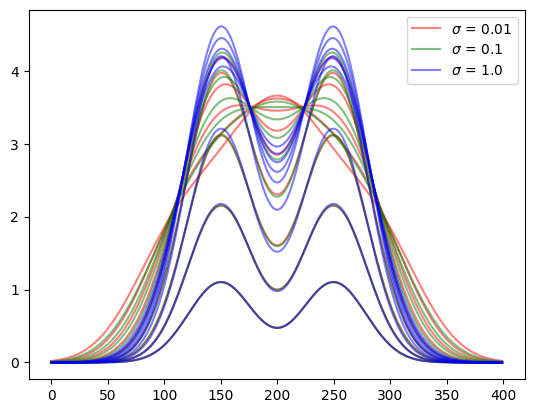

In [ ]:
cs = ['r','g','b']
sigs = [0.01,0.1,1.0]

for c,sig in zip(cs,sigs):

  phis = solve_transport_equation(y0,S,sig,args)

  labels = [f'$\sigma$ = {sig}'] + [None] * (phis.shape[0] - 2)
  plt.plot(phis[1:,:].T,c=c,alpha=0.5,label=labels)

plt.legend()

## Questions

1) What is the purpose of the $w_m$ array?

2) Is it clear why solutions with larger $\sigma$ values spread out more slowly?

3) For $\sigma = 0$ and late times, in which region will $f(\mu > 0) \gg f(\mu < 0)$?

# Part 2

The transport equation above is defined in three dimensions: 1 space, 1 direction and time. It is often the case that multi-dimensional problems are more computationally expensive or present unique numerical challenges. Therefore, reduced models seek to retain some of the dynamics of the full high dimensional model but within reduced dimensions.

For our example, we might be interested in a PDE for the evolution of $\phi(x,t)$ only. By integrating out the $\mu$ dimension of the transport equation, we arrive at the following:

$$ \frac{\partial \phi}{\partial t} = -\frac{\partial F_\phi}{\partial x} + S $$

Where the flux of $\phi$ is:

$$ F_{\phi} = \int \mu f(x,\mu,t) d\mu $$

Diffusion theory suggests a Fick's law for this flux of the form:

$$ F_{\phi} = - D \frac{\partial \phi}{\partial x} $$

Leading to a (potentially non-linear) heat equation:

$$ \frac{\partial \phi}{\partial t} = \frac{\partial }{\partial x}\left( D \frac{\partial \phi}{\partial x} \right) + S $$

Question is, what is $D$? This can be stated as an optimisation problem, for what $D$ is the diffusion solution most similar to the transport solution.

In this part of the exercise we will use optax to train a differentiable simulator

***

As means as of an introduction to optax, we will solve a very simple optimisation problem:

$$
\mathrm{argmin}_p f(p) = \underline{p}^T \cdot \underline{\underline{d}} \cdot \underline{p}
$$

which is trivially solvable with $\underline{p} = \underline{0}$. We will also use this oppurtunity to make use of JAX's random number generators.

Below is some code to set up the problem for randomly generated $\underline{\underline{d}}$ and starting location for the optimisation problem $\underline{p}_0$.

In [ ]:
# RNG initialisation
key = jax.random.key(0)

def example_loss(p,d):
  return jnp.dot(p.T,jnp.dot(d,p))

# Dimension of input space
Np = 10
# Convex shape of input space
d = jax.random.normal(key,shape=(Np,Np))
# Random positive semi-definite
d = jnp.dot(d,d.T)
# Random starting location
key, subkey = jax.random.split(key)
p0 = jax.random.normal(subkey,shape=(Np,))
print(f'Starting loss: {example_loss(p0,d)}')


Starting loss: 173.30865478515625


Optax defines the optimisation workflow through two important components:

1. The optimizer: this defines the optimizer algorithm and uses the gradients of the loss (combined with the optimizer hyperparameters) to update the trainable parameters
2. The optimizer state: this defines the trainable parameters

In the code below, we define these optax components for our simple convex optimisation problem. We also define the gradient of the loss via AD. Finally, we introduce a training loop which iteratively updates the parameters via the adam optimiser.

In [ ]:
# Initialize parameters of the model + optimizer.
learning_rate = 1e-1
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(p0)

# A simple update loop
Nepoch = 200
grad_loss = jax.value_and_grad(example_loss)
p = p0.copy()
history = []
for _ in range(Nepoch):
  loss,grads = grad_loss(p, d)
  # Optax optimizer uses the gradients to update the parameters and the optimiser state
  updates, opt_state = optimizer.update(grads, opt_state)
  p = optax.apply_updates(p, updates)
  history.append(loss)

Plotting the loss history, we see it converging towards the global optimum at 0.

Final p mag: 0.04299479350447655


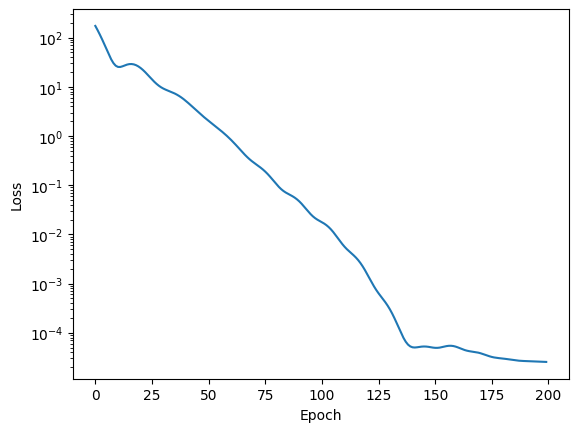

In [ ]:
plt.semilogy(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
print(f'Final p mag: {jnp.linalg.norm(p)}')

With this simple example of how to use optax, we can now apply it to optimising the numerical solution to PDEs.

We must now follow the same exercise of defining our numerical solution to the heat equation. The method of lines finite differencing for the heat equation is as follows:

$$
\frac{\partial \phi_i}{\partial t} = D\frac{\phi_{i-1}-2\phi_{i}+\phi_{i+1}}{\Delta x^2} + S
$$

We will reuse the same solver and stepsize_controller as for the transport equation.

In [ ]:
def heat_equation_dydt(t,y,args):
  Nx = args['Nx']
  D, dx = args['D'], args['dx']
  # Compute finite differences
  y_ghost = jnp.concatenate([y[:1],y,y[-1:]],axis=0)
  dydt = D*(y_ghost[:-2]-2*y_ghost[1:-1]+y_ghost[2:])/dx**2
  # Add isotropic source term
  dydt = dydt+args['S'](t)
  return dydt

# We convert our python JAX function to a diffrax ODETerm
heat_equation_term = diffrax.ODETerm(heat_equation_dydt)

def solve_heat_equation(y0,D,args):
  args['D'] = D
  sol = diffrax.diffeqsolve(heat_equation_term, solver, y0=y0, args = args,
                        t0=t0, t1=t1, dt0=dt0, max_steps=1000000,
                        saveat=saveat, stepsize_controller=stepsize_controller)

  phis = sol.ys
  return phis

In order to find the optimal value of a scalar diffusivity, $D$, we must define a loss function. In this case, we will use the MSE between the $\phi$s calculated by transport and the diffusion approximation evaluated at the SaveAt times:

$$
L \propto \sum_{t \in \mathrm{SaveAt}} \sum_i (\phi_{D,i}(t)-\phi_{i}(t))^2
$$

In [ ]:
def diffusion_to_transport_loss(D,phis_transport,args):
  y_heat_0 = jnp.zeros(args['Nx'])
  phis_heat = solve_heat_equation(y_heat_0,D[0],args)
  # Mean Squared Error
  return jnp.mean((phis_transport-phis_heat)**2)

grad_PDE_loss = jax.value_and_grad(diffusion_to_transport_loss)

We now have all the pieces needed to solve the optimisation problem we have defined in this section.

***

To begin optimising our diffusion PDE solution we must create the training data and initialise the optimiser:

In [ ]:
# Training data
sig = 1.0
phis_transport = solve_transport_equation(y0,S,sig,args)

# Initialize parameters
D_opt = jnp.array([1.0])
diffusion_args = {'Nx' : Nx, 'dx' : dx, 'S' : S}

# Initialize optimizer
learning_rate = 1e-2
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(D_opt)

Next we can set up a very simple training loop analogous to the first simple example we gave of how to use optax

Final D: [0.29137912]


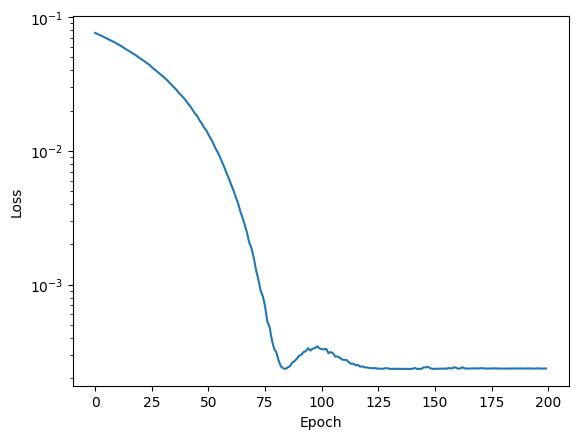

In [ ]:
# A simple update loop
Nepoch = 200
history = []
for _ in range(Nepoch):
  loss,grads = grad_PDE_loss(D_opt,phis_transport,diffusion_args)
  # Optax optimizer uses the gradients to update the parameters and the optimiser state
  updates, opt_state = optimizer.update(grads, opt_state)
  D_opt = optax.apply_updates(D_opt, updates)
  history.append(loss)

plt.semilogy(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
print(f'Final D: {D_opt}')

With our optimal value of $D$, we can visual compare the output of our trained diffusion simulator and the transport solution:

Text(0, 0.5, '$\\phi$')

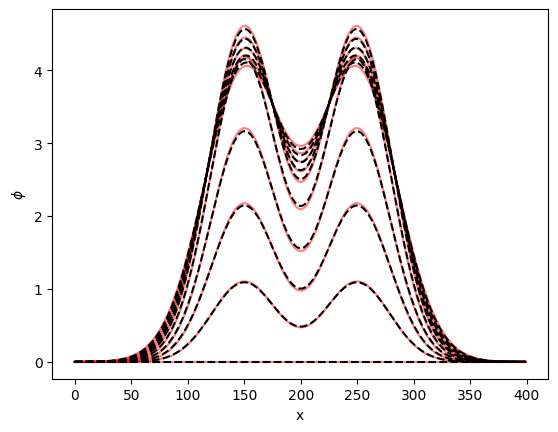

In [ ]:
plt.plot(phis_transport.T,alpha=0.5,c='r')
y_heat_0 = jnp.zeros(args['Nx'])
phis_heat = solve_heat_equation(y_heat_0,D_opt[0],diffusion_args)
plt.plot(phis_heat.T,ls='--',c='k')

plt.xlabel('x')
plt.ylabel(r"$\phi$")

To find the optimal $D$ value for different $\sigma$ values, we can package up the previous initilisation and optimisation code into a function of $\sigma$ only.

Text(0, 0.5, 'Loss')

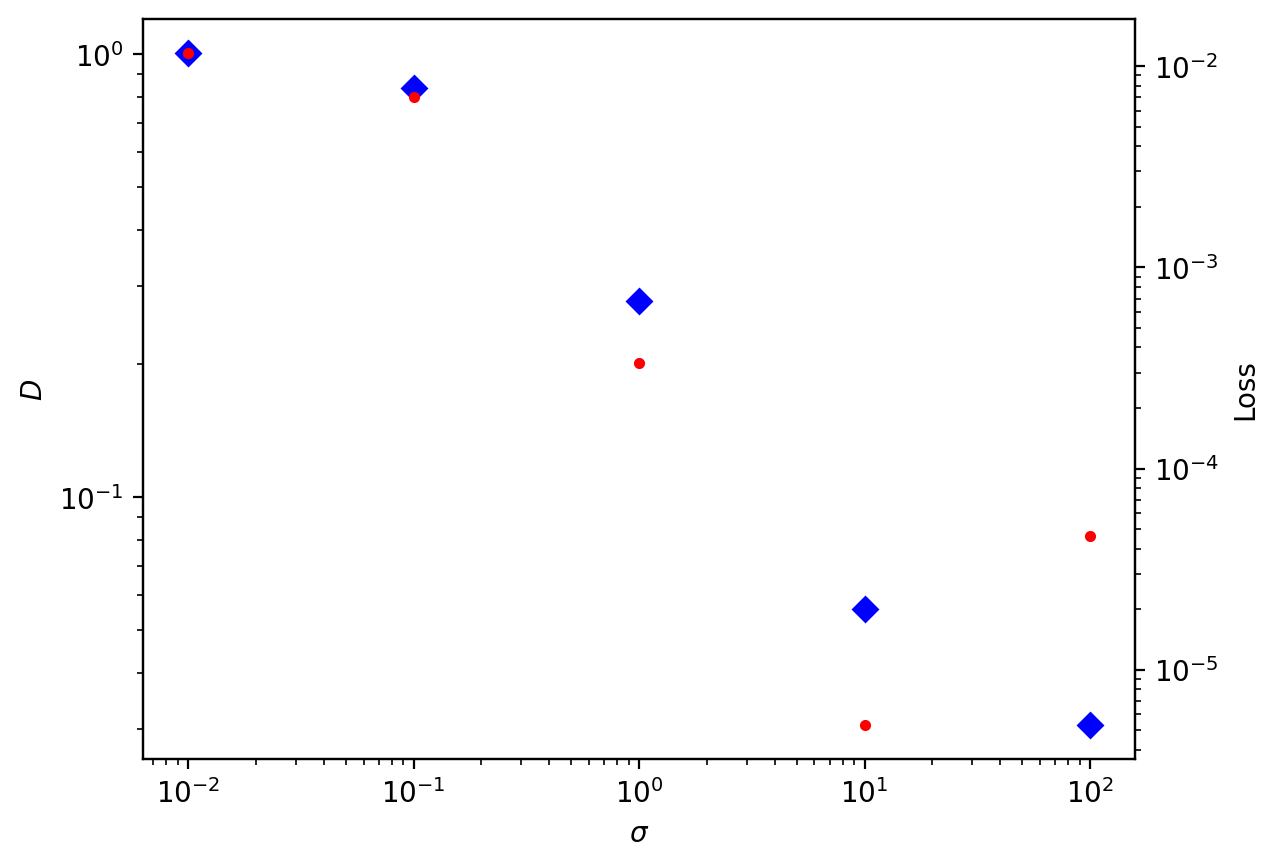

In [ ]:
def optimal_D_for_sig(sig,Nepoch=100,learning_rate=1e-2):
  phis_transport = solve_transport_equation(y0,S,sig,args)

  # Initialize parameters
  D_opt = jnp.array([1.0])
  diffusion_args = {'Nx' : Nx, 'dx' : dx, 'S' : S}

  # Initialize optimizer
  optimizer = optax.adam(learning_rate)
  opt_state = optimizer.init(D_opt)

  # A simple update loop
  for _ in range(Nepoch):
    loss,grads = grad_PDE_loss(D_opt,phis_transport,diffusion_args)
    # Optax optimizer uses the gradients to update the parameters and the optimiser state
    updates, opt_state = optimizer.update(grads, opt_state)
    D_opt = optax.apply_updates(D_opt, updates)

  return D_opt[0],loss

sigs = jnp.array([100.0,10.0,1.0,0.1,0.01])

fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

for sig in sigs:
  D_opt,loss = optimal_D_for_sig(sig)
  ax1.loglog(sig,D_opt,'bD')
  ax2.loglog(sig,loss,'r.')

ax1.set_xlabel('$\sigma$')
ax1.set_ylabel('$D$')
ax2.set_ylabel('Loss')

## Questions

1) Is the diffusion approximation more appropriate for large or small $\sigma$, i.e. for which is a small loss obtainable?

2) Why might one expect $D$ to be a decreasing function of $\sigma$?

3) Can you think of a non-zero source term $S(x,t)$ which would make transport and diffusion solutions equal for any $D$ value?


# Key takeaways

- Differentiable simulators require the following components:
  1. A pre-defined ODE or PDE structure
  2. A number of trainable parameters which are not a-priori known
  3. A numerical scheme for solution (finite differencing, time-stepping, etc.)
  4. A loss function which defines an optimal model
  5. A means to minimise the loss (adjoint solver, optimiser, etc.)
- Diffrax is a JAX library for the numerical solution (both forward and adjoint) of differential equations
- Optax is a JAX library for optimisation which can be easily interfaced with diffrax
